## Task: Prepare Modelling data from the formatted datasets

In [51]:
import pandas as pd
import numpy as np
import re
from collections import defaultdict
from statistics import mode, median
import pickle
import os

from factslab.utility import load_glove_embedding
from factslab.datastructures import ConstituencyTree, DependencyTree
from factslab.pytorch.childsumtreelstm import *
#from pytorch.rnnregression import RNNRegressionTrainer
from factslab.pytorch.rnnregression import RNNRegression

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix
import itertools

##Torch
import torch
from torch.nn import MSELoss, L1Loss, SmoothL1Loss, CrossEntropyLoss

#### Formatted datasets location

In [2]:
home_dir = "/Users"

In [3]:
data_path = "../data/"
ud_trees = home_dir + "/sidvash/Dropbox/facts_lab/UD_data_trees/structures.tsv"
train_file_p1 = "bulk_data_temporal_duration.csv"

#Taken from github - includes doc ids and sent ids
ud_train_detailed =  home_dir +"/sidvash/Dropbox/facts_lab/veridicality_sid/UD_English/en_ewt-ud-train.conllu"
ud_dev_detailed =  home_dir +"/sidvash/Dropbox/facts_lab/veridicality_sid/UD_English/en_ewt-ud-dev.conllu"
ud_test_detailed = home_dir + "/sidvash/Dropbox/facts_lab/veridicality_sid/UD_English/en_ewt-ud-test.conllu"

## Structures object

In [4]:
ud_trees = home_dir +"/sidvash/Dropbox/facts_lab/UD_data_trees/structures.tsv"

struct_dict = {}

with open(ud_trees, 'r') as f:
    structs_sents = [line.strip().split('\t') for line in f]

for sent_id, tree_list, sent in structs_sents:
    struct_dict[sent_id] = DependencyTree.fromstring(tree_list)
    struct_dict[sent_id].sentence = sent.split(" ")
    
print(struct_dict['en-ud-dev.conllu sent_1'].sentence)

['From', 'the', 'AP', 'comes', 'this', 'story', ':']


## Load Data

In [5]:
data_p1 = pd.read_csv(data_path + train_file_p1)

In [6]:
cols = ["split", "worker_id", "sent_token", "sentence_id_1", "sentence_id_2", "sentence", "pred1_text", "pred2_text",
        "pred1_token", "pred2_token", "pred1_root_token", "pred2_root_token", 
       "pred1_duration", "pred2_duration", "pred1_slider", "pred2_slider",
       "pred1_dur_conf", "pred2_dur_conf", "relation_conf", "doc_id"]

out_data = data_p1[cols]

out_data['sent_pred_id1'] = out_data['sentence_id_1'] + " " + out_data['pred1_root_token'].map(lambda x: str(x))
out_data['sent_pred_id2'] = out_data['sentence_id_2'] + " " + out_data['pred2_root_token'].map(lambda x: str(x))

#out_data.head()

## Pre-Process Data

### 1.1 Remove empty slider positions

In [7]:
print(out_data.shape)
out_data = out_data[(out_data.pred1_slider!="{}") &
                   (out_data.pred2_slider!="{}")]
print(out_data.shape)

(85125, 22)
(85124, 22)


### 1.2 Get the slider-values into lists

In [8]:
out_data['pred1_slider_lst'] = out_data['pred1_slider'].map(lambda x: [int(item) for item in x.split("-")])
out_data['pred2_slider_lst'] = out_data['pred2_slider'].map(lambda x: [int(item) for item in x.split("-")])

###  1.3 Extract TIME_ML tags - Coarse and coarser

In [9]:
def time_ml_coarser(row, var1, var2):
    '''
    Creates time ML tags (13 relations) 
    
    from slider positions of two events 
    
    Eg: EVENT 1 "is before" EVENT2
    
    Eg: Relations: is before
    '''
    ans = ""
    
    event1 = getattr(row, var1)
    event2 = getattr(row, var2)
    
    ## For debuggging
    #event1 = var1
    #event2 = var2
    
    b1, e1 = event1
    b2, e2 = event2
    
    if (b1 == b2) and (e1 == e2):
        ans = "simultaneous"
    elif e1 < b2:
        ans = "before"
    
    elif b1 > e2:
        ans = "after"
        
    elif e1 == b2:   #meets
        ans = "ibefore"
        
    elif e2 == b1:
        ans = "iafter"
        
    elif (b1==b2) and (e1 < e2):
        ans="begins"
    
    elif (b1==b2) and (e1 > e2):
        ans="begun_by"
        
    elif (e1==e2) and (b1 > b2):
        ans="ends"
        
    elif (e1==e2) and (b1 < b2):
        ans ="end_by"
        
    elif b2 < b1 and e1 < e2:
        ans = "is_included"
        
    elif b2 > b1 and e1 > e2:
        ans = "includes"
        
    elif b1 < b2 and b2 < e1 and e1 < e2:
        ans = "before_overlaps"
    
    elif b1 > b2 and b1 < e2 and e1 > e2:
        ans = "after_overlaps"
    else:
        ans = "other"
        
    return ans

def time_ml_coarse(row, var1, var2):
    '''
    Creates coarse - time ML tags (7 relations)
    from slider positions of two events 
    
    Eg: EVENT 1 "is before" EVENT2
    
    Eg: Relations: is before
    '''
    ans = ""
    event1 = getattr(row, var1)
    event2 = getattr(row, var2)
    
    ## For debuggging
    #event1 = var1
    #event2 = var2
    
    ans = time_ml_coarser(row, var1, var2)
    
    if ans=="ibefore":
        ans = "before"
    elif ans == "iafter":
        ans = "after"
    elif (ans == "begins") or (ans == "ends"):
        ans = "is_included"
    elif (ans =="begun_by") or (ans =="end_by"):
        ans = "includes"
    
    return ans

In [10]:
## Time-ML check tags
# values = [[[1,4], [6,10]],
# [[6,10], [1,4]],
# [[1,6], [6,10]],
# [[6,10], [1,6]],
# [[1,6], [4,10]],
# [[4,10], [1,6]],
# [[1,4], [1,10]],
# [[1,10], [1,4]],
# [[3,8], [1,10]],
# [[1,10], [3,8]],
# [[4,10], [1,10]],
# [[1,10], [4,10]],
# [[1,10], [1,10]]]

# for item in values:
#     print(time_ml_coarser(3, item[0], item[1]))
# print("\n")
# for item in values:
#     print(time_ml_coarse(3, item[0], item[1]))

In [11]:
out_data['time_ml_coarse'] = out_data.apply(lambda row: time_ml_coarse(row, 
                                                             'pred1_slider_lst', 
                                                             'pred2_slider_lst'),
                                    axis=1)
out_data['time_ml_coarse'] = out_data['time_ml_coarse'].astype('category')
out_data['time_ml_code_coarse'] = out_data['time_ml_coarse'].cat.codes

print(out_data['time_ml_coarse'].cat.categories)

#out_data.head()

Index(['after', 'after_overlaps', 'before', 'before_overlaps', 'includes',
       'is_included', 'simultaneous'],
      dtype='object')


### 1.4 Normalize slider Values

In [12]:
def normalize_sliders(row, var_s1, var_s2,
                     param="slider1"):
    '''
    Input:
    var_min_slider: name of the variable having min slider value
    var_max_slider: name of the variable having max slider value
    var_s1: name of the variable having slider1 values
    var_s1: name of the variable having slider2 values
    
    Output:
    norm_slider1: normalized slider1 values
    norm_slider2: normalized slider2 values
    '''
    b1, e1 = getattr(row, var_s1)
    b2, e2 = getattr(row, var_s2)
    
    min_val = min(b1,e1,b2,e2)
    max_val = max(b1,e1,b2,e2)
    
    if param=="slider1":
        try:
            return [round((b1-min_val)/max_val,4), round((e1-min_val)/max_val, 4)]
        except:
            return [0,0]
    else:
        try:
            return [round((b2-min_val)/max_val,4), round((e2-min_val)/max_val,4)]
        except:
            return [0,0]

In [13]:
out_data['norm_slider1'] = out_data.apply(lambda row: normalize_sliders(row, "pred1_slider_lst", 
                                                                        "pred2_slider_lst",
                                                                        param="slider1"), axis=1)
out_data['norm_slider2'] = out_data.apply(lambda row: normalize_sliders(row, "pred1_slider_lst", 
                                                                        "pred2_slider_lst",
                                                                        param="slider2"), axis=1)
out_data.head()

,split,worker_id,sent_token,sentence_id_1,sentence_id_2,sentence,pred1_text,pred2_text,pred1_token,pred2_token,...,relation_conf,doc_id,sent_pred_id1,sent_pred_id2,pred1_slider_lst,pred2_slider_lst,time_ml_coarse,time_ml_code_coarse,norm_slider1,norm_slider2
0,train,212,en-ud-train.conllu 418_17 en-ud-train.conllu 4...,en-ud-train.conllu 418,en-ud-train.conllu 418,Again there is no official written statement f...,think,is intentional,17,18_19,...,4,10,en-ud-train.conllu 418 17,en-ud-train.conllu 418 19,"[35, 41]","[64, 65]",before,2,"[0.0, 0.0923]","[0.4462, 0.4615]"
1,train,212,en-ud-train.conllu 9490_51 en-ud-train.conllu ...,en-ud-train.conllu 9490,en-ud-train.conllu 9490,Crowds are at their thinnest &#44; but many of...,grey,dark,51,53,...,4,189,en-ud-train.conllu 9490 51,en-ud-train.conllu 9490 53,"[0, 65]","[0, 65]",simultaneous,6,"[0.0, 1.0]","[0.0, 1.0]"
2,train,212,en-ud-train.conllu 7143_8 en-ud-train.conllu 7...,en-ud-train.conllu 7143,en-ud-train.conllu 7144,1&#44;200 - Number of public - diplomacy offic...,employed,be the greatest threats to...,8,11_12_13_14_15_18_19,...,4,83,en-ud-train.conllu 7143 8,en-ud-train.conllu 7144 14,"[0, 81]","[0, 81]",simultaneous,6,"[0.0, 1.0]","[0.0, 1.0]"
3,train,212,en-ud-train.conllu 7786_17 en-ud-train.conllu ...,en-ud-train.conllu 7786,en-ud-train.conllu 7787,If you &#39;re going to go through the trouble...,getting,is a good nano protein...,17,4_5_6_7_8_9,...,4,126,en-ud-train.conllu 7786 17,en-ud-train.conllu 7787 9,"[35, 44]","[0, 100]",is_included,5,"[0.35, 0.44]","[0.0, 1.0]"
4,train,212,en-ud-train.conllu 5729_4 en-ud-train.conllu 5...,en-ud-train.conllu 5729,en-ud-train.conllu 5729,My partners and I solicit your assistance in c...,solicit,served,4,36,...,4,65,en-ud-train.conllu 5729 4,en-ud-train.conllu 5729 36,"[36, 42]","[0, 26]",after,0,"[0.8571, 1.0]","[0.0, 0.619]"


## 2. Ridit Score confidence values 

In [14]:
def ridit_score(x):
    x = x.astype(int)
    x_max, x_min = x.max(), x.min()
    counts = x.value_counts()[list(range(x_max+1))].fillna(0)
    dist = counts/counts.sum()
    cumdist = dist.cumsum()
    
    def _ridit_score(i):
        if i != x_min: 
            return cumdist[i-1] + dist[i]/2
        else:
            return dist[i]/2
        
    return x.apply(_ridit_score)

out_data['relation_conf_ridit'] = out_data.groupby('worker_id').relation_conf.transform(ridit_score)
out_data['pred1_dur_conf_ridit'] = out_data.groupby('worker_id').pred1_dur_conf.transform(ridit_score)
out_data['pred2_dur_conf_ridit'] = out_data.groupby('worker_id').pred2_dur_conf.transform(ridit_score)

## 3. Store median/mean duration/confidence values for dev-test data

In [15]:
def extract_median_mode_mean(data, sent_token_var, 
                             sent_token, median_var,
                            param="median"):
    '''
    Extract median of corresponding var values values of a sent_id
    '''
    answers = list(data[data[sent_token_var] == sent_token][median_var].values)

    if param=="median":
        return int(median(answers))
    elif param=="mean":
        return np.mean(answers)

data_mod = out_data[out_data.split != "train"]

g = data_mod.groupby(['sent_token'])
sent_token_lst = list(g.groups.keys())

## Store median duration and other confidence values:
pred1_dur_dict = {}
pred2_dur_dict = {}
pred1_dur_conf_dict = {}
pred2_dur_conf_dict = {}

rel_conf_dict = {}

for sent_token in sent_token_lst:
    pred1_dur_dict[sent_token] = extract_median_mode_mean(data_mod, 'sent_token', 
                                                          sent_token, 'pred1_duration')
    pred2_dur_dict[sent_token] = extract_median_mode_mean(data_mod, 'sent_token', 
                                                          sent_token, 'pred2_duration')
    pred1_dur_conf_dict[sent_token] = extract_median_mode_mean(data_mod, 'sent_token', 
                                                          sent_token, 'pred1_dur_conf_ridit', param="mean")
    pred2_dur_conf_dict[sent_token] = extract_median_mode_mean(data_mod, 'sent_token', 
                                                          sent_token, 'pred2_dur_conf_ridit', param="mean")
    rel_conf_dict[sent_token] = extract_median_mode_mean(data_mod, 'sent_token', 
                                                          sent_token, 'relation_conf_ridit', param="mean")

In [16]:
len(pred1_dur_dict)

10725

## 3. Extract Timelines

In [17]:
device=torch.device(type="cpu")

class TimelineModel(torch.nn.Module):
    '''
     A class to extract a simple timeline model from a
     given document's predicate-pair data
    '''
    def __init__(self,
                 data = None,
                 num_preds = None,
                 optimizer_class = torch.optim.Adam,
                device=torch.device(type="cpu") ,
                **kwargs):
        super().__init__()

        self.device = device
        self.fine_loss = L1Loss().to(self.device)
        
        self.pred_tensor = torch.nn.Parameter(torch.randn(num_preds,2))
        self._optimizer_class = optimizer_class

    def forward(self, local_data, **kwargs):
        '''
        INput: dataframe with cols:
                b1, e1, b2, e2, pred1_dict_idx, pred2_dict_idx
                
        Output: 
        '''
        t_sq = self.pred_tensor**2 
        
        num_preds= t_sq.size()[0]
        anchored_tensor = torch.zeros(num_preds,2)
        
        anchored_tensor[:,0] = t_sq[:,0] - t_sq[:,0].min()
        anchored_tensor[:,1] = t_sq[:,1]
        
        #Predicted values
        b1 = anchored_tensor[local_data.pred1_dict_idx.values][:,0]
        dur1 = anchored_tensor[local_data.pred1_dict_idx.values][:,1]
        b2 = anchored_tensor[local_data.pred2_dict_idx.values][:,0]
        dur2 = anchored_tensor[local_data.pred2_dict_idx.values][:,1]
        
        return b1, dur1, b2, dur2, anchored_tensor
    
    def fit(self, local_data, epochs=100, **kwargs):
        losses = [10000]
        
        print("#### Model Parameters ####")
        for name,param in self.named_parameters():     
            if param.requires_grad:
                print(name, param.shape) 
        print("##########################") 
        parameters = [p for p in self.parameters() if p.requires_grad]
        optimizer = self._optimizer_class(parameters)
        
        #Actual values
        b1_lst = local_data.b1.values
        e1_lst = local_data.e1.values
        b2_lst = local_data.b2.values
        e2_lst = local_data.e2.values
        
        actuals = self._lsts_to_tensors(b1_lst, e1_lst, b2_lst, e2_lst,
                                        param="float")
        
        for epoch in range(epochs):
            
            preds = self.forward(local_data)
            #zero_grad
            optimizer.zero_grad()
            curr_loss = self._custom_loss(preds, actuals)
            curr_loss.backward()
            optimizer.step()
            
            if epoch==0:
                print("Epoch: {}, Initial-Loss: {}".format(epoch+1, curr_loss))
               
            ## Stop training when loss converges
            if abs(curr_loss.detach() - losses[-1]) < 0.00001:
                print("Epoch: {}, Converging-Loss: {}".format(epoch+1, curr_loss))
                break
                
            losses.append(curr_loss.detach())
                
        return self.predict(preds)
        
    def _custom_loss(self, preds, actuals):
    
        b1_pred, dur1_pred, b2_pred, dur2_pred, _ = preds
        b1_act, e1_act, b2_act, e2_act = actuals
        
        ## Normalize predicted values:
        num_pairs = b1_pred.size()[0]
        t = torch.zeros(num_pairs,4)
        t[:,0] = b1_pred
        t[:,1] = b1_pred + dur1_pred
        t[:,2] = b2_pred
        t[:,3] = b2_pred + dur2_pred
        t_min, _ = torch.min(t,dim=1)
        t_max, _ = torch.max(t,dim=1)
        t = t - t_min.view(num_pairs,1)
        t = t/t_max.view(num_pairs,1)
        
        ## Fine-grained Losses
        l1 = self.fine_loss(t[:,0]-t[:,2], b1_act-b2_act)
        l2 = self.fine_loss(t[:,1]-t[:,2], e1_act-b2_act)
        l3 = self.fine_loss(t[:,3]-t[:,0], e2_act-b1_act)
        l4 = self.fine_loss(t[:,1]-t[:,3], e1_act-e2_act)
        
        a,b,c,d=0.25,0.25,0.25, 0.25 
        total_loss1 = a*l1+ b*l2+ c*l3+ d*l4
        
        ## match exact
        #l5 = self.fine_loss(t[:,0], b1_act)
        #l6 = self.fine_loss(t[:,1], e1_act)
        #l7 = self.fine_loss(t[:,2], b2_act)
        #l8 = self.fine_loss(t[:,3], e2_act)
    
        #total_loss2 = (l5+l6+l7+l8)/4
        
        return total_loss1
        
    def _lsts_to_tensors(self, *args, param=None):
        '''
        Input: list1, list2,......

        Output: [Tensor(list1), tensor(list2),....]

        '''
        if param=="float":
            return [torch.from_numpy(np.array(arg)).float().to(self.device) for arg in args]
        else:
            return [torch.from_numpy(np.array(arg, dtype="int64")).to(self.device) for arg in args]
        
    def predict(self, preds):
        b1_pred, dur1_pred, b2_pred, dur2_pred, pred_timeline = preds
        
        ## Normalize predicted values:
        num_pairs = b1_pred.size()[0]
        t = torch.zeros(num_pairs,4)
        t[:,0] = b1_pred
        t[:,1] = b1_pred + dur1_pred
        t[:,2] = b2_pred
        t[:,3] = b2_pred + dur2_pred
        t_min, _ = torch.min(t,dim=1)
        t_max, _ = torch.max(t,dim=1)
        t = t - t_min.view(num_pairs,1)
        t = (t/t_max.view(num_pairs,1)).detach().numpy()
        

        return t[:,0],t[:,1], t[:,2], t[:,3], pred_timeline.detach().numpy()
        

In [18]:
def extract_preds(doc_id, data, split_data="train"):
    '''
    Extracts a dict of predicates for a given docid and data-split
    Key: pred_sent_id
    Value: predicate-index
    '''
    cols = ['sent_pred_id1', 'sent_pred_id2', 'norm_slider1', 'norm_slider2']
    
    local_data = data[(data.split==split_data) & (out_data.doc_id == doc_id)][cols]
    local_data['b1'] = local_data['norm_slider1'].map(lambda x: x[0])
    local_data['e1'] = local_data['norm_slider1'].map(lambda x: x[1])
    local_data['b2'] = local_data['norm_slider2'].map(lambda x: x[0])
    local_data['e2'] = local_data['norm_slider2'].map(lambda x: x[1])
    
    
    preds_arr = local_data[['sent_pred_id1', 'sent_pred_id2']].values
    uniq_preds = np.unique(preds_arr.flatten())
    
    pred_dict = {}
    idx=0
    for pred in uniq_preds:
        pred_dict[pred]=idx
        idx+=1
        
    local_data['pred1_dict_idx'] = local_data['sent_pred_id1'].map(lambda x: pred_dict[x])
    local_data['pred2_dict_idx'] = local_data['sent_pred_id2'].map(lambda x: pred_dict[x])
        
    return pred_dict, idx, local_data

### Extract Timelines for train-dev-test separately

In [19]:
def extract_predictions(data, split_data="train"):
    '''
    Extract predicted slider values and document timelines for
    a given data
    '''
    data_mod = data[data.split==split_data]
    
    doc_ids = data_mod['doc_id'].unique()
    
    doc_timelines = {}
    
    for i,doc_id in enumerate(doc_ids):
        pred_dict, num_preds, local_data = extract_preds(doc_id, data_mod, 
                                                   split_data=split_data)
        
        ## Run Timeline Model on current docid's data
        model = TimelineModel(data = local_data,
                 num_preds = num_preds,
                device=torch.device(type="cpu"))
        
        pred_b1, pred_e1, pred_b2, pred_e2, pred_timeline  = model.fit(local_data, epochs=100000)
        doc_timelines[doc_id] = pred_timeline
        
        ## Store prediction-values into the dataset
        data_mod.loc[(data_mod.doc_id == doc_id), 
                     'predicted_b1'] = pred_b1
        
        data_mod.loc[(data_mod.doc_id == doc_id), 
                     'predicted_e1'] = pred_e1
        
        data_mod.loc[(data_mod.doc_id == doc_id), 
                     'predicted_b2'] = pred_b2
        
        data_mod.loc[(data_mod.doc_id == doc_id), 
                     'predicted_e2'] = pred_e2

        print("Documents processed: {}, Curr_docid: {}\n".format(i+1, doc_id))
        
        
    return data_mod, doc_timelines

## 2.1 Train_data

In [20]:
train_data, train_doc_timlines = extract_predictions(out_data, split_data="train")

#### Model Parameters ####
pred_tensor torch.Size([171, 2])
##########################
Epoch: 1, Initial-Loss: 0.5102177858352661
Epoch: 1472, Converging-Loss: 0.20063063502311707
Documents processed: 1, Curr_docid: 10

#### Model Parameters ####
pred_tensor torch.Size([136, 2])
##########################
Epoch: 1, Initial-Loss: 0.5644097924232483
Epoch: 1420, Converging-Loss: 0.19585275650024414
Documents processed: 2, Curr_docid: 189

#### Model Parameters ####
pred_tensor torch.Size([309, 2])
##########################
Epoch: 1, Initial-Loss: 0.6178700923919678
Epoch: 1839, Converging-Loss: 0.15799157321453094
Documents processed: 3, Curr_docid: 83

#### Model Parameters ####
pred_tensor torch.Size([34, 2])
##########################
Epoch: 1, Initial-Loss: 0.5146307349205017
Epoch: 1532, Converging-Loss: 0.20157302916049957
Documents processed: 4, Curr_docid: 126

#### Model Parameters ####
pred_tensor torch.Size([66, 2])
##########################
Epoch: 1, Initial-Loss: 0.5996086

Epoch: 1658, Converging-Loss: 0.19962722063064575
Documents processed: 38, Curr_docid: 80

#### Model Parameters ####
pred_tensor torch.Size([55, 2])
##########################
Epoch: 1, Initial-Loss: 0.6100953817367554
Epoch: 1262, Converging-Loss: 0.20604924857616425
Documents processed: 39, Curr_docid: 158

#### Model Parameters ####
pred_tensor torch.Size([206, 2])
##########################
Epoch: 1, Initial-Loss: 0.560792863368988
Epoch: 1773, Converging-Loss: 0.2067868709564209
Documents processed: 40, Curr_docid: 43

#### Model Parameters ####
pred_tensor torch.Size([148, 2])
##########################
Epoch: 1, Initial-Loss: 0.5290388464927673
Epoch: 1220, Converging-Loss: 0.1942145824432373
Documents processed: 41, Curr_docid: 185

#### Model Parameters ####
pred_tensor torch.Size([291, 2])
##########################
Epoch: 1, Initial-Loss: 0.5523849725723267
Epoch: 1352, Converging-Loss: 0.19771067798137665
Documents processed: 42, Curr_docid: 193

#### Model Parameters ####

Documents processed: 75, Curr_docid: 304

#### Model Parameters ####
pred_tensor torch.Size([147, 2])
##########################
Epoch: 1, Initial-Loss: 0.6330231428146362
Epoch: 1621, Converging-Loss: 0.19921858608722687
Documents processed: 76, Curr_docid: 52

#### Model Parameters ####
pred_tensor torch.Size([622, 2])
##########################
Epoch: 1, Initial-Loss: 0.5858017206192017
Epoch: 1660, Converging-Loss: 0.20169003307819366
Documents processed: 77, Curr_docid: 17

#### Model Parameters ####
pred_tensor torch.Size([87, 2])
##########################
Epoch: 1, Initial-Loss: 0.5547586679458618
Epoch: 1400, Converging-Loss: 0.20218650996685028
Documents processed: 78, Curr_docid: 19

#### Model Parameters ####
pred_tensor torch.Size([58, 2])
##########################
Epoch: 1, Initial-Loss: 0.5820478200912476
Epoch: 1438, Converging-Loss: 0.20239898562431335
Documents processed: 79, Curr_docid: 169

#### Model Parameters ####
pred_tensor torch.Size([32, 2])
################

#### Model Parameters ####
pred_tensor torch.Size([78, 2])
##########################
Epoch: 1, Initial-Loss: 0.5759381055831909
Epoch: 1572, Converging-Loss: 0.19731676578521729
Documents processed: 113, Curr_docid: 170

#### Model Parameters ####
pred_tensor torch.Size([8, 2])
##########################
Epoch: 1, Initial-Loss: 0.51714026927948
Epoch: 786, Converging-Loss: 0.14108158648014069
Documents processed: 114, Curr_docid: 388

#### Model Parameters ####
pred_tensor torch.Size([51, 2])
##########################
Epoch: 1, Initial-Loss: 0.5227460265159607
Epoch: 1244, Converging-Loss: 0.1956673413515091
Documents processed: 115, Curr_docid: 522

#### Model Parameters ####
pred_tensor torch.Size([57, 2])
##########################
Epoch: 1, Initial-Loss: 0.49498462677001953
Epoch: 1153, Converging-Loss: 0.17081516981124878
Documents processed: 116, Curr_docid: 529

#### Model Parameters ####
pred_tensor torch.Size([32, 2])
##########################
Epoch: 1, Initial-Loss: 0.5464

Epoch: 1936, Converging-Loss: 0.16473206877708435
Documents processed: 150, Curr_docid: 20

#### Model Parameters ####
pred_tensor torch.Size([22, 2])
##########################
Epoch: 1, Initial-Loss: 0.510085940361023
Epoch: 1439, Converging-Loss: 0.17371124029159546
Documents processed: 151, Curr_docid: 488

#### Model Parameters ####
pred_tensor torch.Size([14, 2])
##########################
Epoch: 1, Initial-Loss: 0.45529448986053467
Epoch: 863, Converging-Loss: 0.17850856482982635
Documents processed: 152, Curr_docid: 394

#### Model Parameters ####
pred_tensor torch.Size([30, 2])
##########################
Epoch: 1, Initial-Loss: 0.6015980839729309
Epoch: 1382, Converging-Loss: 0.23600517213344574
Documents processed: 153, Curr_docid: 510

#### Model Parameters ####
pred_tensor torch.Size([25, 2])
##########################
Epoch: 1, Initial-Loss: 0.592553973197937
Epoch: 1346, Converging-Loss: 0.22120431065559387
Documents processed: 154, Curr_docid: 498

#### Model Parameters 

Epoch: 1585, Converging-Loss: 0.19405759871006012
Documents processed: 187, Curr_docid: 453

#### Model Parameters ####
pred_tensor torch.Size([8, 2])
##########################
Epoch: 1, Initial-Loss: 0.6323316693305969
Epoch: 537, Converging-Loss: 0.3829488158226013
Documents processed: 188, Curr_docid: 210

#### Model Parameters ####
pred_tensor torch.Size([138, 2])
##########################
Epoch: 1, Initial-Loss: 0.575684666633606
Epoch: 1642, Converging-Loss: 0.21472367644309998
Documents processed: 189, Curr_docid: 8

#### Model Parameters ####
pred_tensor torch.Size([22, 2])
##########################
Epoch: 1, Initial-Loss: 0.7880498170852661
Epoch: 1657, Converging-Loss: 0.23819130659103394
Documents processed: 190, Curr_docid: 472

#### Model Parameters ####
pred_tensor torch.Size([59, 2])
##########################
Epoch: 1, Initial-Loss: 0.5654622316360474
Epoch: 1379, Converging-Loss: 0.1876523643732071
Documents processed: 191, Curr_docid: 151

#### Model Parameters ###

Documents processed: 224, Curr_docid: 435

#### Model Parameters ####
pred_tensor torch.Size([34, 2])
##########################
Epoch: 1, Initial-Loss: 0.49351757764816284
Epoch: 1293, Converging-Loss: 0.16229891777038574
Documents processed: 225, Curr_docid: 124

#### Model Parameters ####
pred_tensor torch.Size([32, 2])
##########################
Epoch: 1, Initial-Loss: 0.528140664100647
Epoch: 1383, Converging-Loss: 0.2279503345489502
Documents processed: 226, Curr_docid: 505

#### Model Parameters ####
pred_tensor torch.Size([25, 2])
##########################
Epoch: 1, Initial-Loss: 0.6946779489517212
Epoch: 2101, Converging-Loss: 0.18308627605438232
Documents processed: 227, Curr_docid: 462

#### Model Parameters ####
pred_tensor torch.Size([18, 2])
##########################
Epoch: 1, Initial-Loss: 0.7064303159713745
Epoch: 1176, Converging-Loss: 0.17623087763786316
Documents processed: 228, Curr_docid: 392

#### Model Parameters ####
pred_tensor torch.Size([78, 2])
###########

#### Model Parameters ####
pred_tensor torch.Size([11, 2])
##########################
Epoch: 1, Initial-Loss: 0.6104606986045837
Epoch: 1122, Converging-Loss: 0.21677839756011963
Documents processed: 262, Curr_docid: 305

#### Model Parameters ####
pred_tensor torch.Size([28, 2])
##########################
Epoch: 1, Initial-Loss: 0.5622200965881348
Epoch: 1075, Converging-Loss: 0.20265522599220276
Documents processed: 263, Curr_docid: 114

#### Model Parameters ####
pred_tensor torch.Size([30, 2])
##########################
Epoch: 1, Initial-Loss: 0.5031026601791382
Epoch: 1211, Converging-Loss: 0.20138460397720337
Documents processed: 264, Curr_docid: 494

#### Model Parameters ####
pred_tensor torch.Size([26, 2])
##########################
Epoch: 1, Initial-Loss: 0.7321414947509766
Epoch: 1538, Converging-Loss: 0.2649326026439667
Documents processed: 265, Curr_docid: 473

#### Model Parameters ####
pred_tensor torch.Size([32, 2])
##########################
Epoch: 1, Initial-Loss: 0.5

#### Model Parameters ####
pred_tensor torch.Size([12, 2])
##########################
Epoch: 1, Initial-Loss: 0.7418789863586426
Epoch: 1276, Converging-Loss: 0.16877393424510956
Documents processed: 299, Curr_docid: 348

#### Model Parameters ####
pred_tensor torch.Size([19, 2])
##########################
Epoch: 1, Initial-Loss: 0.7429022192955017
Epoch: 2081, Converging-Loss: 0.1915208250284195
Documents processed: 300, Curr_docid: 413

#### Model Parameters ####
pred_tensor torch.Size([65, 2])
##########################
Epoch: 1, Initial-Loss: 0.6188557147979736
Epoch: 1712, Converging-Loss: 0.16895784437656403
Documents processed: 301, Curr_docid: 171

#### Model Parameters ####
pred_tensor torch.Size([13, 2])
##########################
Epoch: 1, Initial-Loss: 0.6720253229141235
Epoch: 1623, Converging-Loss: 0.19414463639259338
Documents processed: 302, Curr_docid: 228

#### Model Parameters ####
pred_tensor torch.Size([31, 2])
##########################
Epoch: 1, Initial-Loss: 0.6

#### Model Parameters ####
pred_tensor torch.Size([21, 2])
##########################
Epoch: 1, Initial-Loss: 0.5061758756637573
Epoch: 1645, Converging-Loss: 0.20454686880111694
Documents processed: 336, Curr_docid: 411

#### Model Parameters ####
pred_tensor torch.Size([75, 2])
##########################
Epoch: 1, Initial-Loss: 0.5381152033805847
Epoch: 1180, Converging-Loss: 0.15838687121868134
Documents processed: 337, Curr_docid: 21

#### Model Parameters ####
pred_tensor torch.Size([11, 2])
##########################
Epoch: 1, Initial-Loss: 0.6261890530586243
Epoch: 1271, Converging-Loss: 0.18788515031337738
Documents processed: 338, Curr_docid: 246

#### Model Parameters ####
pred_tensor torch.Size([20, 2])
##########################
Epoch: 1, Initial-Loss: 0.6004949808120728
Epoch: 1959, Converging-Loss: 0.1671828180551529
Documents processed: 339, Curr_docid: 432

#### Model Parameters ####
pred_tensor torch.Size([20, 2])
##########################
Epoch: 1, Initial-Loss: 0.51

Epoch: 1915, Converging-Loss: 0.17381063103675842
Documents processed: 373, Curr_docid: 519

#### Model Parameters ####
pred_tensor torch.Size([6, 2])
##########################
Epoch: 1, Initial-Loss: 0.49805349111557007
Epoch: 692, Converging-Loss: 0.10529586672782898
Documents processed: 374, Curr_docid: 301

#### Model Parameters ####
pred_tensor torch.Size([21, 2])
##########################
Epoch: 1, Initial-Loss: 0.6117038726806641
Epoch: 1501, Converging-Loss: 0.1451074481010437
Documents processed: 375, Curr_docid: 416

#### Model Parameters ####
pred_tensor torch.Size([36, 2])
##########################
Epoch: 1, Initial-Loss: 0.6050717830657959
Epoch: 1383, Converging-Loss: 0.24281975626945496
Documents processed: 376, Curr_docid: 116

#### Model Parameters ####
pred_tensor torch.Size([20, 2])
##########################
Epoch: 1, Initial-Loss: 0.5693414211273193
Epoch: 1426, Converging-Loss: 0.18589583039283752
Documents processed: 377, Curr_docid: 404

#### Model Parameters

Documents processed: 410, Curr_docid: 328

#### Model Parameters ####
pred_tensor torch.Size([6, 2])
##########################
Epoch: 1, Initial-Loss: 0.5312210917472839
Epoch: 700, Converging-Loss: 0.27635517716407776
Documents processed: 411, Curr_docid: 206

#### Model Parameters ####
pred_tensor torch.Size([11, 2])
##########################
Epoch: 1, Initial-Loss: 0.5435611009597778
Epoch: 1369, Converging-Loss: 0.13355670869350433
Documents processed: 412, Curr_docid: 293

#### Model Parameters ####
pred_tensor torch.Size([10, 2])
##########################
Epoch: 1, Initial-Loss: 0.7121933102607727
Epoch: 1603, Converging-Loss: 0.1476815938949585
Documents processed: 413, Curr_docid: 333

#### Model Parameters ####
pred_tensor torch.Size([23, 2])
##########################
Epoch: 1, Initial-Loss: 0.6056182980537415
Epoch: 902, Converging-Loss: 0.20345094799995422
Documents processed: 414, Curr_docid: 454

#### Model Parameters ####
pred_tensor torch.Size([13, 2])
##############

#### Model Parameters ####
pred_tensor torch.Size([5, 2])
##########################
Epoch: 1, Initial-Loss: 0.5332976579666138
Epoch: 710, Converging-Loss: 0.21684229373931885
Documents processed: 448, Curr_docid: 208

#### Model Parameters ####
pred_tensor torch.Size([30, 2])
##########################
Epoch: 1, Initial-Loss: 0.6344200968742371
Epoch: 1576, Converging-Loss: 0.16851939260959625
Documents processed: 449, Curr_docid: 155

#### Model Parameters ####
pred_tensor torch.Size([18, 2])
##########################
Epoch: 1, Initial-Loss: 0.5383607149124146
Epoch: 917, Converging-Loss: 0.18164394795894623
Documents processed: 450, Curr_docid: 424

#### Model Parameters ####
pred_tensor torch.Size([13, 2])
##########################
Epoch: 1, Initial-Loss: 0.5066408514976501
Epoch: 743, Converging-Loss: 0.23750323057174683
Documents processed: 451, Curr_docid: 299

#### Model Parameters ####
pred_tensor torch.Size([14, 2])
##########################
Epoch: 1, Initial-Loss: 0.5793

Epoch: 1487, Converging-Loss: 0.23281364142894745
Documents processed: 485, Curr_docid: 256

#### Model Parameters ####
pred_tensor torch.Size([14, 2])
##########################
Epoch: 1, Initial-Loss: 0.6906894445419312
Epoch: 1606, Converging-Loss: 0.18815071880817413
Documents processed: 486, Curr_docid: 300

#### Model Parameters ####
pred_tensor torch.Size([7, 2])
##########################
Epoch: 1, Initial-Loss: 0.6908633708953857
Epoch: 1437, Converging-Loss: 0.13565300405025482
Documents processed: 487, Curr_docid: 204

#### Model Parameters ####
pred_tensor torch.Size([9, 2])
##########################
Epoch: 1, Initial-Loss: 0.6453616619110107
Epoch: 847, Converging-Loss: 0.24790479242801666
Documents processed: 488, Curr_docid: 212

#### Model Parameters ####
pred_tensor torch.Size([8, 2])
##########################
Epoch: 1, Initial-Loss: 0.5375292301177979
Epoch: 154, Converging-Loss: 0.4257120192050934
Documents processed: 489, Curr_docid: 248

#### Model Parameters ###

Documents processed: 522, Curr_docid: 226

#### Model Parameters ####
pred_tensor torch.Size([14, 2])
##########################
Epoch: 1, Initial-Loss: 0.692674994468689
Epoch: 1167, Converging-Loss: 0.34136295318603516
Documents processed: 523, Curr_docid: 356

#### Model Parameters ####
pred_tensor torch.Size([8, 2])
##########################
Epoch: 1, Initial-Loss: 0.3761720657348633
Epoch: 982, Converging-Loss: 0.12925374507904053
Documents processed: 524, Curr_docid: 239

#### Model Parameters ####
pred_tensor torch.Size([7, 2])
##########################
Epoch: 1, Initial-Loss: 0.3764137327671051
Epoch: 358, Converging-Loss: 0.17472027242183685
Documents processed: 525, Curr_docid: 291

#### Model Parameters ####
pred_tensor torch.Size([9, 2])
##########################
Epoch: 1, Initial-Loss: 0.534756064414978
Epoch: 914, Converging-Loss: 0.1544630378484726
Documents processed: 526, Curr_docid: 221

#### Model Parameters ####
pred_tensor torch.Size([10, 2])
###################

In [21]:
train_data['predicted_slider1'] = train_data.apply(lambda row: [round(row.predicted_b1,4) , 
                                                                round(row.predicted_e1,4)], axis=1)
train_data['predicted_slider2'] = train_data.apply(lambda row: [round(row.predicted_b2,4), 
                                                                round(row.predicted_e2,4)], axis=1)
train_data['predicted_timeml'] = train_data.apply(lambda row: time_ml_coarse(row, 
                                                             'predicted_slider1', 
                                                             'predicted_slider2'),
                                                                    axis=1)
train_data.drop(['predicted_b1','predicted_e1', 'predicted_b2',  'predicted_e2'],axis=1, inplace=True)
train_data.head()

,split,worker_id,sent_token,sentence_id_1,sentence_id_2,sentence,pred1_text,pred2_text,pred1_token,pred2_token,...,time_ml_coarse,time_ml_code_coarse,norm_slider1,norm_slider2,relation_conf_ridit,pred1_dur_conf_ridit,pred2_dur_conf_ridit,predicted_slider1,predicted_slider2,predicted_timeml
0,train,212,en-ud-train.conllu 418_17 en-ud-train.conllu 4...,en-ud-train.conllu 418,en-ud-train.conllu 418,Again there is no official written statement f...,think,is intentional,17,18_19,...,before,2,"[0.0, 0.0923]","[0.4462, 0.4615]",0.583832,0.576647,0.623353,"[0.0, 0.1538]","[0.0278, 0.2112]",before_overlaps
1,train,212,en-ud-train.conllu 9490_51 en-ud-train.conllu ...,en-ud-train.conllu 9490,en-ud-train.conllu 9490,Crowds are at their thinnest &#44; but many of...,grey,dark,51,53,...,simultaneous,6,"[0.0, 1.0]","[0.0, 1.0]",0.583832,0.576647,0.623353,"[0.0038, 0.7372]","[0.0, 0.7299]",after_overlaps
2,train,212,en-ud-train.conllu 7143_8 en-ud-train.conllu 7...,en-ud-train.conllu 7143,en-ud-train.conllu 7144,1&#44;200 - Number of public - diplomacy offic...,employed,be the greatest threats to...,8,11_12_13_14_15_18_19,...,simultaneous,6,"[0.0, 1.0]","[0.0, 1.0]",0.583832,0.576647,0.623353,"[0.0451, 0.7936]","[0.0, 0.7939]",is_included
3,train,212,en-ud-train.conllu 7786_17 en-ud-train.conllu ...,en-ud-train.conllu 7786,en-ud-train.conllu 7787,If you &#39;re going to go through the trouble...,getting,is a good nano protein...,17,4_5_6_7_8_9,...,is_included,5,"[0.35, 0.44]","[0.0, 1.0]",0.583832,0.576647,0.623353,"[0.1513, 0.4399]","[0.0, 0.8015]",is_included
4,train,212,en-ud-train.conllu 5729_4 en-ud-train.conllu 5...,en-ud-train.conllu 5729,en-ud-train.conllu 5729,My partners and I solicit your assistance in c...,solicit,served,4,36,...,after,0,"[0.8571, 1.0]","[0.0, 0.619]",0.583832,0.576647,0.623353,"[0.639, 0.8757]","[0.0, 0.5104]",after


In [47]:
train_data.to_pickle(data_path + "pre_processed/train_preprocessed.pkl")
#train_doc_timlines.to_pickle(data_path + "pre_processed/train_timelines.pkl")

In [48]:
def save_obj(obj, name ):
    with open(data_path + name + '.pkl', 'wb+') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(data_path + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
save_obj(train_doc_timlines, "pre_processed/train_timelines.pkl")

## 2.2 Dev Data

In [23]:
dev_data, dev_doc_timlines = extract_predictions(out_data, split_data="dev")

#### Model Parameters ####
pred_tensor torch.Size([23, 2])
##########################
Epoch: 1, Initial-Loss: 0.5756314992904663
Epoch: 1648, Converging-Loss: 0.27608388662338257
Documents processed: 1, Curr_docid: 6

#### Model Parameters ####
pred_tensor torch.Size([14, 2])
##########################
Epoch: 1, Initial-Loss: 0.5174899101257324
Epoch: 1220, Converging-Loss: 0.2523316442966461
Documents processed: 2, Curr_docid: 100

#### Model Parameters ####
pred_tensor torch.Size([95, 2])
##########################
Epoch: 1, Initial-Loss: 0.5776270627975464
Epoch: 1432, Converging-Loss: 0.2743568420410156
Documents processed: 3, Curr_docid: 14

#### Model Parameters ####
pred_tensor torch.Size([35, 2])
##########################
Epoch: 1, Initial-Loss: 0.5611345767974854
Epoch: 1162, Converging-Loss: 0.26278847455978394
Documents processed: 4, Curr_docid: 7

#### Model Parameters ####
pred_tensor torch.Size([41, 2])
##########################
Epoch: 1, Initial-Loss: 0.552354395389556

Epoch: 1107, Converging-Loss: 0.25383177399635315
Documents processed: 38, Curr_docid: 95

#### Model Parameters ####
pred_tensor torch.Size([10, 2])
##########################
Epoch: 1, Initial-Loss: 0.5845240950584412
Epoch: 1002, Converging-Loss: 0.30492261052131653
Documents processed: 39, Curr_docid: 39

#### Model Parameters ####
pred_tensor torch.Size([17, 2])
##########################
Epoch: 1, Initial-Loss: 0.5244674682617188
Epoch: 1012, Converging-Loss: 0.2766019105911255
Documents processed: 40, Curr_docid: 113

#### Model Parameters ####
pred_tensor torch.Size([18, 2])
##########################
Epoch: 1, Initial-Loss: 0.5910168290138245
Epoch: 1411, Converging-Loss: 0.2650994062423706
Documents processed: 41, Curr_docid: 50

#### Model Parameters ####
pred_tensor torch.Size([8, 2])
##########################
Epoch: 1, Initial-Loss: 0.741685152053833
Epoch: 969, Converging-Loss: 0.32005906105041504
Documents processed: 42, Curr_docid: 83

#### Model Parameters ####
pred_t

#### Model Parameters ####
pred_tensor torch.Size([14, 2])
##########################
Epoch: 1, Initial-Loss: 0.562077522277832
Epoch: 764, Converging-Loss: 0.30948299169540405
Documents processed: 76, Curr_docid: 116

#### Model Parameters ####
pred_tensor torch.Size([5, 2])
##########################
Epoch: 1, Initial-Loss: 0.7594197392463684
Epoch: 1024, Converging-Loss: 0.26752158999443054
Documents processed: 77, Curr_docid: 232

#### Model Parameters ####
pred_tensor torch.Size([8, 2])
##########################
Epoch: 1, Initial-Loss: 0.6664911508560181
Epoch: 1072, Converging-Loss: 0.25715795159339905
Documents processed: 78, Curr_docid: 316

#### Model Parameters ####
pred_tensor torch.Size([8, 2])
##########################
Epoch: 1, Initial-Loss: 0.6284805536270142
Epoch: 1538, Converging-Loss: 0.2460421621799469
Documents processed: 79, Curr_docid: 82

#### Model Parameters ####
pred_tensor torch.Size([7, 2])
##########################
Epoch: 1, Initial-Loss: 0.665338873863

Epoch: 1084, Converging-Loss: 0.3066760301589966
Documents processed: 113, Curr_docid: 94

#### Model Parameters ####
pred_tensor torch.Size([9, 2])
##########################
Epoch: 1, Initial-Loss: 0.5814998149871826
Epoch: 986, Converging-Loss: 0.2887990474700928
Documents processed: 114, Curr_docid: 90

#### Model Parameters ####
pred_tensor torch.Size([5, 2])
##########################
Epoch: 1, Initial-Loss: 0.759549617767334
Epoch: 404, Converging-Loss: 0.2983265519142151
Documents processed: 115, Curr_docid: 235

#### Model Parameters ####
pred_tensor torch.Size([9, 2])
##########################
Epoch: 1, Initial-Loss: 0.5688861012458801
Epoch: 869, Converging-Loss: 0.25442662835121155
Documents processed: 116, Curr_docid: 318

#### Model Parameters ####
pred_tensor torch.Size([3, 2])
##########################
Epoch: 1, Initial-Loss: 0.40485018491744995
Epoch: 443, Converging-Loss: 0.17164281010627747
Documents processed: 117, Curr_docid: 258

#### Model Parameters ####
pred_

#### Model Parameters ####
pred_tensor torch.Size([3, 2])
##########################
Epoch: 1, Initial-Loss: 1.2503167390823364
Epoch: 756, Converging-Loss: 0.3096977770328522
Documents processed: 151, Curr_docid: 256

#### Model Parameters ####
pred_tensor torch.Size([4, 2])
##########################
Epoch: 1, Initial-Loss: 0.6679696440696716
Epoch: 625, Converging-Loss: 0.2764691114425659
Documents processed: 152, Curr_docid: 207

#### Model Parameters ####
pred_tensor torch.Size([15, 2])
##########################
Epoch: 1, Initial-Loss: 0.6414580345153809
Epoch: 1097, Converging-Loss: 0.28850919008255005
Documents processed: 153, Curr_docid: 3

#### Model Parameters ####
pred_tensor torch.Size([6, 2])
##########################
Epoch: 1, Initial-Loss: 0.7697511911392212
Epoch: 973, Converging-Loss: 0.23203180730342865
Documents processed: 154, Curr_docid: 77

#### Model Parameters ####
pred_tensor torch.Size([7, 2])
##########################
Epoch: 1, Initial-Loss: 0.730744659900

Epoch: 971, Converging-Loss: 0.28541868925094604
Documents processed: 188, Curr_docid: 84

#### Model Parameters ####
pred_tensor torch.Size([3, 2])
##########################
Epoch: 1, Initial-Loss: 0.5615975856781006
Epoch: 1022, Converging-Loss: 0.273869127035141
Documents processed: 189, Curr_docid: 35

#### Model Parameters ####
pred_tensor torch.Size([3, 2])
##########################
Epoch: 1, Initial-Loss: 0.8112460970878601
Epoch: 180, Converging-Loss: 0.7346691489219666
Documents processed: 190, Curr_docid: 248

#### Model Parameters ####
pred_tensor torch.Size([2, 2])
##########################
Epoch: 1, Initial-Loss: 0.6668969392776489
Epoch: 409, Converging-Loss: 0.38788333535194397
Documents processed: 191, Curr_docid: 175

#### Model Parameters ####
pred_tensor torch.Size([5, 2])
##########################
Epoch: 1, Initial-Loss: 0.6512142419815063
Epoch: 734, Converging-Loss: 0.289460152387619
Documents processed: 192, Curr_docid: 199

#### Model Parameters ####
pred_te

#### Model Parameters ####
pred_tensor torch.Size([3, 2])
##########################
Epoch: 1, Initial-Loss: 0.2579059600830078
Epoch: 260, Converging-Loss: 0.1758735328912735
Documents processed: 226, Curr_docid: 228

#### Model Parameters ####
pred_tensor torch.Size([2, 2])
##########################
Epoch: 1, Initial-Loss: 0.9639889001846313
Epoch: 520, Converging-Loss: 0.2589166462421417
Documents processed: 227, Curr_docid: 239

#### Model Parameters ####
pred_tensor torch.Size([2, 2])
##########################
Epoch: 1, Initial-Loss: 0.7397079467773438
Epoch: 581, Converging-Loss: 0.1805500090122223
Documents processed: 228, Curr_docid: 253

#### Model Parameters ####
pred_tensor torch.Size([2, 2])
##########################
Epoch: 1, Initial-Loss: 0.5963173508644104
Epoch: 854, Converging-Loss: 0.21024999022483826
Documents processed: 229, Curr_docid: 284

#### Model Parameters ####
pred_tensor torch.Size([2, 2])
##########################
Epoch: 1, Initial-Loss: 0.722888231277

In [24]:
dev_data['predicted_slider1'] = dev_data.apply(lambda row: [round(row.predicted_b1,4) , 
                                                                round(row.predicted_e1,4)], axis=1)
dev_data['predicted_slider2'] = dev_data.apply(lambda row: [round(row.predicted_b2,4), 
                                                                round(row.predicted_e2,4)], axis=1)
dev_data['predicted_timeml_coarse'] = dev_data.apply(lambda row: time_ml_coarse(row, 
                                                             'predicted_slider1', 
                                                             'predicted_slider2'),
                                                                    axis=1)
dev_data.drop(['predicted_b1','predicted_e1', 'predicted_b2',  'predicted_e2'],axis=1, inplace=True)
#dev_data.head()
print(dev_data.shape)

(16304, 34)


In [25]:
## Restore only the top row by sent_token:
dev_data = dev_data.groupby(['sent_token']).first().reset_index()
print(dev_data.shape)
    
## Replace duration and confidence values with median/mean values
dev_data['pred1_duration'] = dev_data.apply(lambda row: pred1_dur_dict[row.sent_token], axis=1)
dev_data['pred2_duration'] = dev_data.apply(lambda row: pred2_dur_dict[row.sent_token], axis=1)
dev_data['pred1_dur_conf_ridit'] = dev_data.apply(lambda row: pred1_dur_conf_dict[row.sent_token], axis=1)
dev_data['pred2_dur_conf_ridit'] = dev_data.apply(lambda row: pred2_dur_conf_dict[row.sent_token], axis=1)
dev_data['relation_conf_ridit'] = dev_data.apply(lambda row: rel_conf_dict[row.sent_token], axis=1)

## Drop variables that don't make sense:
cols_drop = ['worker_id', 'pred1_slider', 'pred2_slider', 
             'pred1_slider_lst', 'pred2_slider_lst',
            'time_ml_coarse', 'time_ml_code_coarse', 
            'norm_slider1', 'norm_slider2']

dev_data = dev_data.drop(cols_drop, axis=1)



(5613, 34)


In [49]:
dev_data.to_pickle(data_path + "pre_processed/dev_preprocessed.pkl")
save_obj(dev_doc_timlines, "pre_processed/dev_timelines.pkl")

## 2.3 Test Data

In [27]:
test_data, test_doc_timlines = extract_predictions(out_data, split_data="test")

#### Model Parameters ####
pred_tensor torch.Size([54, 2])
##########################
Epoch: 1, Initial-Loss: 0.551242470741272
Epoch: 1641, Converging-Loss: 0.2531256079673767
Documents processed: 1, Curr_docid: 9

#### Model Parameters ####
pred_tensor torch.Size([13, 2])
##########################
Epoch: 1, Initial-Loss: 0.6102219820022583
Epoch: 990, Converging-Loss: 0.28004923462867737
Documents processed: 2, Curr_docid: 299

#### Model Parameters ####
pred_tensor torch.Size([83, 2])
##########################
Epoch: 1, Initial-Loss: 0.5605191588401794
Epoch: 1265, Converging-Loss: 0.26492512226104736
Documents processed: 3, Curr_docid: 37

#### Model Parameters ####
pred_tensor torch.Size([12, 2])
##########################
Epoch: 1, Initial-Loss: 0.6676499843597412
Epoch: 1235, Converging-Loss: 0.22958961129188538
Documents processed: 4, Curr_docid: 108

#### Model Parameters ####
pred_tensor torch.Size([40, 2])
##########################
Epoch: 1, Initial-Loss: 0.58037525415420

Epoch: 1726, Converging-Loss: 0.28081926703453064
Documents processed: 38, Curr_docid: 5

#### Model Parameters ####
pred_tensor torch.Size([10, 2])
##########################
Epoch: 1, Initial-Loss: 0.6623401641845703
Epoch: 1282, Converging-Loss: 0.2921375632286072
Documents processed: 39, Curr_docid: 309

#### Model Parameters ####
pred_tensor torch.Size([98, 2])
##########################
Epoch: 1, Initial-Loss: 0.6137878894805908
Epoch: 1462, Converging-Loss: 0.2926584780216217
Documents processed: 40, Curr_docid: 14

#### Model Parameters ####
pred_tensor torch.Size([25, 2])
##########################
Epoch: 1, Initial-Loss: 0.6017427444458008
Epoch: 1285, Converging-Loss: 0.2581021189689636
Documents processed: 41, Curr_docid: 58

#### Model Parameters ####
pred_tensor torch.Size([10, 2])
##########################
Epoch: 1, Initial-Loss: 0.5302261114120483
Epoch: 836, Converging-Loss: 0.30318379402160645
Documents processed: 42, Curr_docid: 308

#### Model Parameters ####
pred_

#### Model Parameters ####
pred_tensor torch.Size([7, 2])
##########################
Epoch: 1, Initial-Loss: 0.7414536476135254
Epoch: 1578, Converging-Loss: 0.2651987373828888
Documents processed: 76, Curr_docid: 269

#### Model Parameters ####
pred_tensor torch.Size([37, 2])
##########################
Epoch: 1, Initial-Loss: 0.5420060157775879
Epoch: 2335, Converging-Loss: 0.2587660551071167
Documents processed: 77, Curr_docid: 12

#### Model Parameters ####
pred_tensor torch.Size([16, 2])
##########################
Epoch: 1, Initial-Loss: 0.5593588352203369
Epoch: 1261, Converging-Loss: 0.3049469292163849
Documents processed: 78, Curr_docid: 119

#### Model Parameters ####
pred_tensor torch.Size([19, 2])
##########################
Epoch: 1, Initial-Loss: 0.6869885921478271
Epoch: 1437, Converging-Loss: 0.27838945388793945
Documents processed: 79, Curr_docid: 126

#### Model Parameters ####
pred_tensor torch.Size([10, 2])
##########################
Epoch: 1, Initial-Loss: 0.566218793

Epoch: 983, Converging-Loss: 0.2364034205675125
Documents processed: 113, Curr_docid: 56

#### Model Parameters ####
pred_tensor torch.Size([5, 2])
##########################
Epoch: 1, Initial-Loss: 0.5574098229408264
Epoch: 751, Converging-Loss: 0.30511677265167236
Documents processed: 114, Curr_docid: 275

#### Model Parameters ####
pred_tensor torch.Size([3, 2])
##########################
Epoch: 1, Initial-Loss: 0.6571676731109619
Epoch: 777, Converging-Loss: 0.24823585152626038
Documents processed: 115, Curr_docid: 40

#### Model Parameters ####
pred_tensor torch.Size([4, 2])
##########################
Epoch: 1, Initial-Loss: 0.39164817333221436
Epoch: 766, Converging-Loss: 0.20384885370731354
Documents processed: 116, Curr_docid: 167

#### Model Parameters ####
pred_tensor torch.Size([8, 2])
##########################
Epoch: 1, Initial-Loss: 0.459157794713974
Epoch: 508, Converging-Loss: 0.23066703975200653
Documents processed: 117, Curr_docid: 307

#### Model Parameters ####
pred

#### Model Parameters ####
pred_tensor torch.Size([10, 2])
##########################
Epoch: 1, Initial-Loss: 0.5059970617294312
Epoch: 938, Converging-Loss: 0.2558020353317261
Documents processed: 151, Curr_docid: 52

#### Model Parameters ####
pred_tensor torch.Size([6, 2])
##########################
Epoch: 1, Initial-Loss: 0.53319251537323
Epoch: 878, Converging-Loss: 0.31396719813346863
Documents processed: 152, Curr_docid: 46

#### Model Parameters ####
pred_tensor torch.Size([6, 2])
##########################
Epoch: 1, Initial-Loss: 0.8519887328147888
Epoch: 1072, Converging-Loss: 0.292643278837204
Documents processed: 153, Curr_docid: 302

#### Model Parameters ####
pred_tensor torch.Size([8, 2])
##########################
Epoch: 1, Initial-Loss: 0.6175127029418945
Epoch: 1121, Converging-Loss: 0.24393418431282043
Documents processed: 154, Curr_docid: 304

#### Model Parameters ####
pred_tensor torch.Size([5, 2])
##########################
Epoch: 1, Initial-Loss: 0.7624765038490

Epoch: 461, Converging-Loss: 0.2912648916244507
Documents processed: 188, Curr_docid: 256

#### Model Parameters ####
pred_tensor torch.Size([7, 2])
##########################
Epoch: 1, Initial-Loss: 0.48811066150665283
Epoch: 1155, Converging-Loss: 0.25623559951782227
Documents processed: 189, Curr_docid: 297

#### Model Parameters ####
pred_tensor torch.Size([6, 2])
##########################
Epoch: 1, Initial-Loss: 0.6071943044662476
Epoch: 1108, Converging-Loss: 0.24380084872245789
Documents processed: 190, Curr_docid: 315

#### Model Parameters ####
pred_tensor torch.Size([5, 2])
##########################
Epoch: 1, Initial-Loss: 0.5425938367843628
Epoch: 1256, Converging-Loss: 0.17761510610580444
Documents processed: 191, Curr_docid: 225

#### Model Parameters ####
pred_tensor torch.Size([5, 2])
##########################
Epoch: 1, Initial-Loss: 0.4523997902870178
Epoch: 723, Converging-Loss: 0.22775831818580627
Documents processed: 192, Curr_docid: 222

#### Model Parameters ###

#### Model Parameters ####
pred_tensor torch.Size([3, 2])
##########################
Epoch: 1, Initial-Loss: 0.33710017800331116
Epoch: 138, Converging-Loss: 0.30947431921958923
Documents processed: 226, Curr_docid: 172

#### Model Parameters ####
pred_tensor torch.Size([2, 2])
##########################
Epoch: 1, Initial-Loss: 0.8266386389732361
Epoch: 522, Converging-Loss: 0.23509272933006287
Documents processed: 227, Curr_docid: 247

#### Model Parameters ####
pred_tensor torch.Size([3, 2])
##########################
Epoch: 1, Initial-Loss: 0.39457765221595764
Epoch: 530, Converging-Loss: 0.23902083933353424
Documents processed: 228, Curr_docid: 235

#### Model Parameters ####
pred_tensor torch.Size([2, 2])
##########################
Epoch: 1, Initial-Loss: 0.6088130474090576
Epoch: 200, Converging-Loss: 0.28270289301872253
Documents processed: 229, Curr_docid: 161

#### Model Parameters ####
pred_tensor torch.Size([3, 2])
##########################
Epoch: 1, Initial-Loss: 0.6173794

In [28]:
test_data['predicted_slider1'] = test_data.apply(lambda row: [round(row.predicted_b1,4) , 
                                                                round(row.predicted_e1,4)], axis=1)
test_data['predicted_slider2'] = test_data.apply(lambda row: [round(row.predicted_b2,4), 
                                                                round(row.predicted_e2,4)], axis=1)
test_data['predicted_timeml_coarse'] = test_data.apply(lambda row: time_ml_coarse(row, 
                                                             'predicted_slider1', 
                                                             'predicted_slider2'),
                                                                    axis=1)
test_data.drop(['predicted_b1','predicted_e1', 'predicted_b2',  'predicted_e2'],axis=1, inplace=True)
test_data.head()
print(test_data.shape)

(14910, 34)


In [29]:
## Restore only the top row by sent_token:
test_data = test_data.groupby(['sent_token']).first().reset_index()
print(test_data.shape)
    
## Replace duration and confidence values with median/mean values
test_data['pred1_duration'] = test_data.apply(lambda row: pred1_dur_dict[row.sent_token], axis=1)
test_data['pred2_duration'] = test_data.apply(lambda row: pred2_dur_dict[row.sent_token], axis=1)
test_data['pred1_dur_conf_ridit'] = test_data.apply(lambda row: pred1_dur_conf_dict[row.sent_token], axis=1)
test_data['pred2_dur_conf_ridit'] = test_data.apply(lambda row: pred2_dur_conf_dict[row.sent_token], axis=1)
test_data['relation_conf_ridit'] = test_data.apply(lambda row: rel_conf_dict[row.sent_token], axis=1)

## Drop variables that don't make sense:
cols_drop = ['worker_id', 'pred1_slider', 'pred2_slider', 
             'pred1_slider_lst', 'pred2_slider_lst',
            'time_ml_coarse', 'time_ml_code_coarse', 
            'norm_slider1', 'norm_slider2']

test_data = test_data.drop(cols_drop, axis=1)

(5112, 34)


In [50]:
test_data.to_pickle(data_path + "pre_processed/test_preprocessed.pkl")
save_obj(test_doc_timlines, "pre_processed/test_timelines.pkl")

## 3. Predicted-Relations Statistics

In [31]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27

In [32]:
match = sum(train_data['time_ml_coarse'] == train_data['predicted_timeml'])
total = train_data.shape[0]
print("% of Relations remained same: {}".format(match/total))

% of Relations remained same: 0.45959933222036725


In [34]:
time_tags = list(train_data['time_ml_coarse'].unique())

before             17357
includes           11058
is_included         8899
before_overlaps     5865
simultaneous        5734
after               4080
after_overlaps       917
Name: time_ml_coarse, dtype: int64


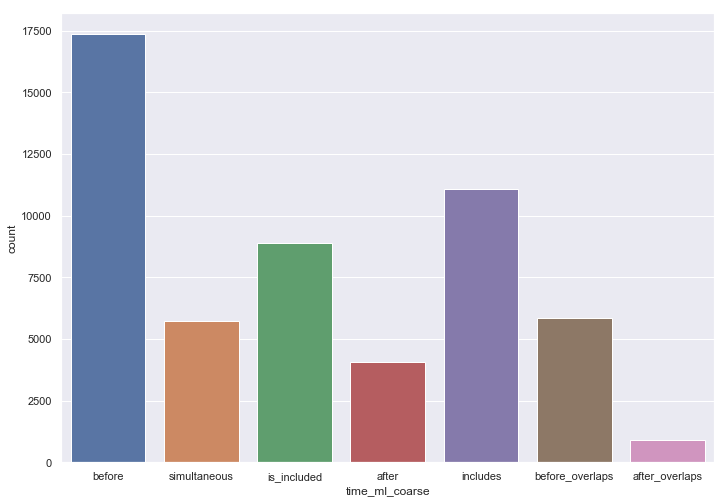

In [35]:
print(train_data.time_ml_coarse.value_counts())
sns.countplot(x='time_ml_coarse', order=time_tags, data=train_data)
plt.show()

before_overlaps    15872
before             10261
includes            9765
is_included         9721
after_overlaps      5676
after               2608
simultaneous           7
Name: predicted_timeml, dtype: int64


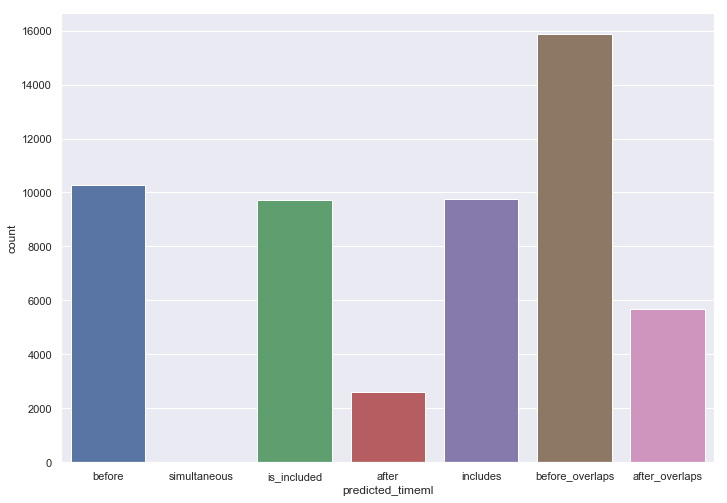

In [36]:
print(train_data.predicted_timeml.value_counts())
sns.countplot(x='predicted_timeml', order=time_tags, data=train_data)
plt.show()

### 3.1 Confusion Matrix

In [37]:
time_tags = train_data.time_ml_coarse.unique()
time_tags

[before, simultaneous, is_included, after, includes, before_overlaps, after_overlaps]
Categories (7, object): [before, simultaneous, is_included, after, includes, before_overlaps, after_overlaps]

In [38]:
conf_matrix = confusion_matrix(train_data.time_ml_coarse, train_data.predicted_timeml, labels=time_tags)

In [39]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[8372    0 1699  246 1060 5501  479]
 [ 206    7 1261   86 1331 1732 1111]
 [ 373    0 4820  175  493 2039  999]
 [ 107    0  336 1776  410  295 1156]
 [ 521    0  692  184 5756 2700 1205]
 [ 661    0  811   68  557 3544  224]
 [  21    0  102   73  158   61  502]]


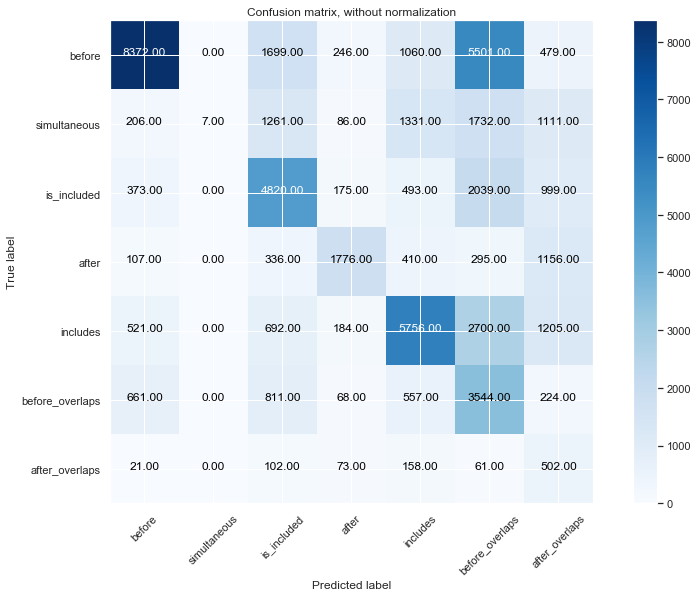

In [40]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_matrix, classes=time_tags, normalize=False,
                      title='Confusion matrix, without normalization')

plt.show()


## 4. Document Timeline - Example

In [41]:
def extract_pred_text(lst, data):
    '''
    Input: A list of sent_pred tokens
    Output: A list of predicate text
    '''
    ans = []
    for sent_pred in lst:
        try:
            pred_text = data[(data.sent_pred_id1==sent_pred)]['pred1_text'].values[0]
            ans.append(pred_text)
        except:
            pred_text = data[(data.sent_pred_id2==sent_pred)]['pred2_text'].values[0]
            ans.append(pred_text)
            
    return ans

def extract_timeline_df(docid, data):
    '''
    Extract a timeline_df for a given docid and data
    '''
    cols = ['sent_pred_id1', 'sent_pred_id2', 'pred1_text', 'pred2_text',
            'doc_id', 'norm_slider1', 'norm_slider2']
    
    local_data = data[(data.doc_id == docid)][cols]
    preds_arr = local_data[['sent_pred_id1', 'sent_pred_id2']].values
    uniq_preds = np.unique(preds_arr.flatten())
    #print(uniq_preds)
    
    preds_text = extract_pred_text(uniq_preds, local_data)
    
    ans_df = pd.DataFrame(data=train_doc_timlines[docid], 
                         columns=['start_pt', 'duration'])
    ans_df['sent_pred_id'] = uniq_preds
    ans_df['pred_text'] = preds_text
    ans_df['doc_id'] = docid
    
    return ans_df

def load_ud_english(fpath):
    """Load a file from the UD English corpus

    Parameters
    ----------
    fpath : str
        Path to UD corpus file ending in .conllu
        
    Output: Returns a list equal to length of total num of docs
            with each item contaiing the first index of sentence
            in that doc
    """

    n = 1

    fname = os.path.split(fpath)[1]

    parses = defaultdict(list)
    sent_ids = []
    newdoc_ids = []
    
    for l in open(fpath):
        ident = fname+' '+str(n)
        
        if re.match(r'\# newdoc id', l):
            newdoc_ids.append(n)
            #newdoc_ids.append(l.split("=")[-1].strip())
            
        if re.match(r'^\d', l):
            l_split = l.strip().split()
            parses[ident].append(l_split)
        
        elif parses[ident]:
            sent_ids.append(ident)
            n += 1

    return newdoc_ids, len(sent_ids)

def extract_sent_to_docid_dict(path_list):
    '''
    Input: ewt_ud .conllu file path
    
    Output: A dict with keys: sent_id, value: doc_id
    '''
    sent_to_doc_dict = {}
    
    for ud_ewt_path in path_list:
        doc_lst, total_sents = load_ud_english(ud_ewt_path)
        data_name = ud_ewt_path.split("ud-")[-1].split(".")[0]
        string = "en-ud-" + data_name + ".conllu" + " "

        len_doc_lst = len(doc_lst)
        
        for i in range(len_doc_lst-1):
            for sent_idx in range(doc_lst[i], doc_lst[i+1]):
                sent_to_doc_dict[string + str(sent_idx)] = str(i+1)

        #Last document:
        for sent_idx in range(doc_lst[-1], total_sents+1):
            sent_to_doc_dict[string + str(sent_idx)] = str(len_doc_lst)
    
    return sent_to_doc_dict

def extract_docid_to_sentid_dict(path_list):
    '''
    Input: ewt_ud .conllu file path
    
    Output: A dict with keys: sent_id, value: doc_id
    '''
    doc_to_sent_dict = {}
    
    for ud_ewt_path in path_list:
        doc_lst, total_sents = load_ud_english(ud_ewt_path)
        data_name = ud_ewt_path.split("ud-")[-1].split(".")[0]
        string = "en-ud-" + data_name + ".conllu" + " "

        len_doc_lst = len(doc_lst)
        
        #Data dict
        doc_to_sent_dict[data_name] = defaultdict(list)
        
        for i in range(len_doc_lst-1):
            for sent_idx in range(doc_lst[i], doc_lst[i+1]):
                sent_string = string + "sent_" + str(sent_idx)
                doc_to_sent_dict[data_name][i+1].append(sent_string)

        #Last document:
        for sent_idx in range(doc_lst[-1], total_sents+1):
            sent_string = string + "sent_" + str(sent_idx)
            doc_to_sent_dict[data_name][len_doc_lst].append(sent_string)
                
    return doc_to_sent_dict

In [42]:
extract_timeline_df(353, train_data).to_csv("timeline_example.csv", index=False)

In [43]:
extract_timeline_df(353, train_data)

,start_pt,duration,sent_pred_id,pred_text,doc_id
0,0.107253,0.129046,en-ud-train.conllu 10690 2,got,353
1,0.464634,1.080031,en-ud-train.conllu 10690 9,missed,353
2,0.611661,0.145337,en-ud-train.conllu 10691 18,was so excited,353
3,0.722593,0.404707,en-ud-train.conllu 10691 21,wanted,353
4,0.797044,0.373317,en-ud-train.conllu 10691 23,go,353
5,0.000000,2.158159,en-ud-train.conllu 10691 25,test,353
6,0.315186,0.099849,en-ud-train.conllu 10691 4,told,353
7,0.066097,0.497601,en-ud-train.conllu 10692 4,was perfect,353
8,0.270688,0.037692,en-ud-train.conllu 10693 3,was better then,353
9,0.075254,0.232085,en-ud-train.conllu 10693 9,tasted,353


## Extract Doc-Sentences

In [44]:
ud_ewt_paths = [ud_train_detailed, ud_dev_detailed, ud_test_detailed]
#sent_to_docid_dict = extract_sent_to_docid_dict(ud_ewt_paths)
doc_to_sent_dict = extract_docid_to_sentid_dict(ud_ewt_paths)

In [45]:
for sent in doc_to_sent_dict['train'][353]:
    print(" ".join(struct_dict[sent].sentence))

AMAZINGLY YUMMY !
I just got back from france yesterday and just missed the food already !
My sister in law told me about this amazing new crepe place in town , I was so excited I just wanted to go and test it out for my self !
Their customer service was perfect !
Their Food was better then anything I had ever tasted .
EVEN IN FRANCE !
I would highly recommend this place to anyone looking for a great atmosphere , amazing food , and great customer service !
Thank you Roll UP Crepes !


## Rough for debugging 

## Run an example

In [ ]:
# split_data= "dev"
# doc_id = 9

In [ ]:
# pred_dict, num_preds, local_data = extract_preds(doc_id, out_data, split_data=split_data)
# print(num_preds)
# local_data.head()

In [ ]:
# # Run Timeline Model on current docid's data
# model = TimelineModel(data = local_data,
#          num_preds = num_preds,
#         device=torch.device(type="cpu"))

# pred_b1, pred_e1, pred_b2, pred_e2, pred_timeline  = model.fit(local_data, epochs=100000)
# #doc_timelines[doc_id] = pred_timeline

In [ ]:
# len(pred_b1)

In [ ]:
# pred_timeline.shape

In [ ]:
# data_mod = out_data[out_data.split==split_data]

In [ ]:
# data_mod.shape

In [ ]:
# ## Store prediction-values into the dataset
# data_mod.loc[(data_mod.doc_id == doc_id), 
#              'predicted_b1'] = pred_b1

# data_mod.loc[(data_mod.doc_id == doc_id), 
#              'predicted_e1'] = pred_e1

# data_mod.loc[(data_mod.doc_id == doc_id), 
#              'predicted_b2'] = pred_b2

# data_mod.loc[(data_mod.doc_id == doc_id), 
#              'predicted_e2'] = pred_e2

# ## Restore only the top row by doc_id and sent_token:
# data_mod = data_mod.groupby(['sent_token']).first().reset_index()
    
    
# ## Replace duration and confidence values with median/mean values
# data_mod['pred1_duration'] = data_mod.apply(lambda row: pred1_dur_dict[row.sent_token], axis=1)
# data_mod['pred2_duration'] = data_mod.apply(lambda row: pred2_dur_dict[row.sent_token], axis=1)
# data_mod['pred1_dur_conf'] = data_mod.apply(lambda row: pred1_dur_conf_dict[row.sent_token], axis=1)
# data_mod['pred2_dur_conf'] = data_mod.apply(lambda row: pred2_dur_conf_dict[row.sent_token], axis=1)
# data_mod['relation_conf'] = data_mod.apply(lambda row: rel_conf_dict[row.sent_token], axis=1)

# ## Drop variables that don't make sense:
# cols_drop = ['worker_id', 'pred1_slider', 'pred2_slider', 
#              'pred1_slider_lst', 'pred2_slider_lst',
#             'time_ml_coarse', 'time_ml_code_coarse', 
#             'norm_slider1', 'norm_slider2']

# data_mod = data_mod.drop(cols_drop, axis=1)

In [ ]:
# data_mod.shape

In [ ]:
# sent_token = 'en-ud-dev.conllu 74_22 en-ud-dev.conllu 74_25'
# data_mod.loc[(data_mod.doc_id == doc_id) &
#             (data_mod.sent_token==sent_token)]